# Judging Books By Their Cover Part 3: Multi-Label Classifier

Welcome to Part-3 of the project, "Judging Books By Their Cover". In this notebook, we will create our multi-label genre classifier.

**What is multi-label classification?**

Multi-label classification refers to the problem of identifying the categories for input data that may belong to multiple categories simultaneously. There may be more than one label for the input data, or there may be no matching labels at all. This approach is excellent for problems like genre classification, where each input text represents a unique blend of different genres. Furthermore, the flexibility of this approach allows us to take care of situations where the input data does not belong to any of the categories in the dataset. This saves us from generating wrong predictions which can be misleading or harmful.

So, let's get started!!!


## Setup

Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


*Where is the dataset?*


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle/GenreClassification" 
%cd /content/gdrive/My Drive/kaggle/GenreClassification

/content/gdrive/My Drive/kaggle/GenreClassification


*What's in the directory?*

In [4]:
!ls

book_data.csv			     sf_cyberpunk.csv
dls_lm.pickle			     sf_dystopia.csv
kaggle.json			     sf_hard.csv
models				     sf_military.csv
science-fiction-books-subgenres.zip  sf_robots.csv
sf_aliens.csv			     sf_space_opera.csv
sf_alternate_history.csv	     sf_steampunk.csv
sf_alternate_universe.csv	     sf_time_travel.csv
sf_apocalyptic.csv		     Wordcloud.png


Let's install the updated version of FastAI

In [5]:
! [ -e /content ] && pip install -Uqq fastai

## Data Preprocessing

To build our multi-label classifier, we need to first preprocess the data and create the dataloader. After the dataloader is created, we can use the language model built in Part-1 to create our custom classifier. 

First, let's import  the essential libraries

In [6]:
import ast
import pandas as pd
from fastai.text.all import *

Loading the dataset

In [7]:
book_data=pd.read_csv('book_data.csv')

*How many labels do we actually have?*

In [8]:
labels=list()
for i in book_data.iterrows():
    dict_genre= ast.literal_eval(i[1]['Genres']) #dictionaries are already sorted
    labels.extend(list(dict_genre.keys()))
print(f"We have {len(set(labels))} labels")        

We have 524 labels


*How many times is each genre mentioned?*

In [9]:
counts = {}
for n in labels:
    counts[n] = counts.get(n, 0) + 1
print(counts)

{'Fantasy': 11118, 'Young Adult': 3924, 'Science Fiction (Dystopia) ': 4018, 'Fiction': 12609, 'Young Adult (Young Adult Fantasy) ': 643, 'Science Fiction': 12248, 'Audiobook': 4248, 'Mystery': 1780, 'Family': 65, 'Young Adult (Teen) ': 959, 'War (Military Fiction) ': 1905, 'Science Fiction (Military Science Fiction) ': 1568, 'Space (Space Opera) ': 2988, 'Science Fiction (Alternate History) ': 1465, 'Space': 2744, 'Science Fiction (Hard Science Fiction) ': 427, 'Science Fiction Fantasy': 5617, 'Action': 928, 'Sequential Art (Graphic Novels) ': 938, 'Sequential Art (Comics) ': 919, 'Horror': 1475, 'Historical (Historical Fiction) ': 2346, 'Graphic Novels Comics': 554, 'Comics (Comic Book) ': 452, 'Historical': 1960, 'Thriller': 1220, 'Suspense': 237, 'Novels': 1671, 'Adventure': 4142, 'Thriller (Mystery Thriller) ': 168, 'Sequential Art (Manga) ': 256, 'Science Fiction (Cyberpunk) ': 1233, 'Manga (Seinen) ': 87, 'Comics Manga': 141, 'Novella': 582, 'Short Stories': 1096, 'Artificial In

Some genres like Horror (Lovecraftian), Paranormal (Fairies), etc are mentioned less than 50 times in the whole dataset. A model that is trained on the dataset will not be able to detect such genres which a high accuracy. Moreover, after splitting the dataset into a training and test set, the number of instances for such genres in the training set will decrease further.

In the previous notebook, we also saw how some genres like Fiction, Fantasy,Science Fiction are mentioned in 70-80% of the rows in the dataset.This means that if we randomly assign these labels to books, we would be right 70-80% of the time. Moreover, the dataset also has sub-genres for genres like Sci-Fi, Fantasy, etc.

It's better to remove these labels from our dataset. 

In [10]:
to_remove=["Fiction","Fantasy","Science Fiction"] #labels which need to be removed
for i,j in counts.items():
  if j<50: #removing all labels with count less than 50
    to_remove.append(i)
to_remove[:10]    

['Fiction',
 'Fantasy',
 'Science Fiction',
 'Science Fiction R... (Steampunk Romance) ',
 'Young Adult (Young Adult Romance) ',
 'Horror (Lovecraftian) ',
 'Fantasy (Dark Fantasy) ',
 'Young Adult (High School) ',
 'Paranormal (Fairies) ',
 'European Literature (Polish Literature) ']

*How many labels are we left with?*

In [11]:
524-len(to_remove)

144

In the previous notebook, while creating word clouds, we created a function to get the most important labels for each row in the dataset. We are going to use the same function here. 





In [12]:
def get_labels(string):
    d=ast.literal_eval(string)
    for key in [key for key in d if key in to_remove]: del d[key]
    s=sum(d.values())
    genre_pct=[(i,(d[i]/s)*100) for i in d]
    genre_pct.sort(key=lambda y: y[1],reverse=True)
    add=0
    labels=[]
    for i in genre_pct:
      if add<=90:
        labels.append(i[0])
        add+=i[1]
    return labels

Getting the labels

In [13]:
book_data['labels']=list(map(get_labels,book_data['Genres']))

If there are any rows which have no labels we should remove them

In [14]:
def to_keep(labels): 
    if len(labels)==0:
      return False
    else:
      return True

After removing the rows with no labels, we will create a `DataFrame` which only contains the independent variable (book description) and the dependent variable (genres) 

In [15]:
book_data['to_keep']=list(map(to_keep,book_data['labels']))
book_data=book_data[book_data['to_keep']==True]
df=book_data[['Book_Description','labels']]

Size of the DataFrame

In [16]:
df.shape

(14906, 2)

*What does it look like?*

In [17]:
df

,Book_Description,labels
0,"There are no secrets in Saintstone.From the second you're born, every achievement, every failing, every significant moment are all immortalized on your skin. There are honorable marks that let people know you're trustworthy. And shameful tattoos that announce you as a traitor. After her father dies, Leora finds solace in the fact that his skin tells a wonderful story. That is, until she glimpses a mark on the back of his neck...the symbol of the worst crime a person can commit in Saintstone. Leora knows it has to be a mistake, but before she can do anything about it, the horrifying secret ...","[Young Adult, Science Fiction (Dystopia) , Young Adult (Young Adult Fantasy) , Audiobook]"
1,"The revelations on Mars -- a half-million year-old legacy of the vanished star-traveling Builders -- have fed the flames of catastrophic war. A beleaguered United States and its Russian and Japanese allies struggle to hold their own against the indomitable forces of the enemy United Nations. The bloody conflict that has swept over the home planet now rages across the blackness of space -- with the U.S. Marine Corps in the vanguard, leading the charge as always.But Mars is not the sole repository of alien wonders. The Earth's moon hides unsettling mysteries of its own-and dangerous secrets ...","[War (Military Fiction) , Science Fiction (Military Science Fiction) , Space (Space Opera) , Science Fiction (Alternate History) , Space, Science Fiction (Hard Science Fiction) , Science Fiction Fantasy]"
2,"In 1804, Captain Meriwether Lewis and Second Lieutenant William Clark set out on an expedition to explore the uncharted American frontier. This is the story of the monsters they discovered lurking in the wilds...Collects MANIFEST DESTINY #1-6.","[Sequential Art (Graphic Novels) , Sequential Art (Comics) , Horror, Historical (Historical Fiction) , Graphic Novels Comics]"
3,"In the Nevada desert, an experiment has gone horribly wrong. A cloud of nanoparticles -- micro-robots -- has escaped from the laboratory. This cloud is self-sustaining and self-reproducing. It is intelligent and learns from experience. For all practical purposes, it is alive.It has been programmed as a predator. It is evolving swiftly, becoming more deadly with each passing hour.Every attempt to destroy it has failed.And we are the prey.","[Thriller, Horror, Suspense, Mystery, Science Fiction Fantasy, Novels]"
4,"Alita's death sentence is commuted in exchange for her service as a member of the Tuned, an elite force of the utopian city of Tiphares. Her first assignment is to protect a nuclear-powered train from the infamous bandit known as Barjack.","[Sequential Art (Manga) , Sequential Art (Comics) , Sequential Art (Graphic Novels) , Science Fiction (Cyberpunk) ]"
...,...,...
14969,"Brave New World is a dystopian novel by English author Aldous Huxley, written in 1931 and published in 1932. Largely set in a futuristic World State, inhabited by genetically modified citizens and an intelligence-based social hierarchy, the novel anticipates huge scientific advancements in reproductive technology, sleep-learning, psychological manipulation and classical conditioning that are combined to make a dystopian society which is challenged by only a single individual: the story's protagonist.","[Classics, Science Fiction (Dystopia) , Literature, Novels]"
14970,"Let the world burn.With an iron fist, the Great Library controls the knowledge of the world, ruthlessly stamping out all rebellion and, in the name of the greater good, forbidding the personal ownership of books.Jess Brightwell has survived his introduction to the sinister, seductive world of the Library, but serving in its army is nothing like he envisioned. His life and the lives of those he cares for have been altered forever. His best friend is lost, and Morgan, the girl he loves, is locked away in the Iron Tower, doomed to a life apart from everything she knows.After embarking on a mi...","[Young Adult, Sc

In Part-1 of this project, we created a language model fine-tuned on our dataset. After creating the dataloader for the language model, we saved it for later use. We are going to use that its vocabulary for creating the dataloader for our multi-label classifier.

Let's load the dataloader of the language model

In [25]:
import pickle 
with open('dls_lm.pickle','rb') as f:
  dls_lm=pickle.load(f)

Now, we will create the DataBlock for our multi-label classifier.

To create a `DataBlock`, we need to pass in the following details:

* Type of independent and dependent variable (our independent variables are book descriptions and the dependent variables are genres )
* A function to get the independent variables or book descriptions in our case (`get_x`) .
* A function to get the values of the dependent variable, which are the labels/genres (`get_y`).
* A method to split the dataset into training and validation set (`splitter`).

That's all!!!

It's important to note that all of the text preprocessing is taken care of by FastAI. This makes the process extremely convenient and also reduces any chances of errors.

We can create the dataloader from our Datablock using the `datablock.dataloaders()` method.



In [26]:
datablock=DataBlock(
    blocks=(TextBlock.from_df('Book_Description',is_lm=False,seq_len=72,vocab=dls_lm.vocab),MultiCategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('labels'),
    splitter=TrainTestSplitter())
dls_gc=datablock.dataloaders(df,bs=128) # batch size=128

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


*What does a batch in the dataloader look like?*

In [27]:
dls_gc.show_batch(max_n=5)

,text,None
0,"xxbos xxmaj markham and the xxmaj anal xxunk then there was the day when xxmaj markham managed to get himself snatched by aliens – or so we thought at the xxunk was summoned to xxmaj dr xxmaj bairstow ’s office to find xxmaj markham and xxmaj peterson already present . xxmaj we looked at each other . xxunk clues ? ’ i xxunk shrugged . xxunk can go in now , ’ said xxmaj mrs xxmaj partridge , so in we xxunk looked up from his desk . ‘ there you are . ’we agreed that yes , here we xxunk xxunk at his xxunk table on which xxunk several archive boxes and a fat folder . xxunk xxmaj county xxmaj archivist has been good enough to make available various documents requested by xxmaj dr xxmaj xxunk . a condition was that we do not expose them to the hazards",Historical;Historical (Historical Fiction) ;Humor;Science Fiction (Alternate History) ;Science Fiction (Time Travel) ;Short Stories
1,"xxbos xxmaj an anthology of the classic short tales of the xxmaj time xxmaj patrol , the future organization that xxunk the continuity of human history . xxmaj forget minor hazards like nuclear bombs . xxmaj the discovery of time travel means that everything we know , anyone we know , might not only vanish , but never even have existed . xxmaj against that possibility stand the men and women of the xxmaj time xxmaj patrol , dedicated to preserving the history they know and protecting the future from fanatics , terrorists , and would - be dictators who would xxunk the shape of reality to suit their own purposes . xxmaj but xxmaj manse xxmaj everard , the xxmaj patrol 's finest temporal trouble - shooter , bears a heavy burden . xxmaj the fabric of history is stained with human blood and suffering which he can not",Adventure;Historical (Historical Fiction) ;Science Fiction (Alternate History) ;Science Fiction (Time Travel)
2,"xxbos xxup series description : in the center of xxmaj long xxmaj island 's forbidden wasteland , overseen by a large and powerful corporation known as xxmaj arc xxmaj properties , is xxup gameland , a virtual reality xxunk where the rich and privileged act out their base fantasies using zombies as avatars . xxmaj connected to their xxmaj infected xxmaj players via neural implants ( government - xxunk in the event of an outbreak ) , xxmaj operators pit the xxmaj undead against one another using remote gaming controllers in a high stakes game of money , violence , and power . xxmaj for the poor , the televised action on state - controlled xxmaj media streams is horrifying yet powerfully addictive . xxmaj volunteering to become an xxmaj undead xxmaj player is strictly forbidden , but fame and money lure some to xxmaj the xxunk a whim ,",Apocalyptic (Post Apocalyptic) ;Horror;Horror (Zombies) ;Science Fiction (Apocalyptic) ;Science Fiction (Cyberpunk)
3,"xxbos xxup fifteen - time xxup winner xxup of xxup the xxup locus xxup award xxup for xxup year 's xxup best xxunk thirty - three stories in this collection xxunk take us far across the universe , into the very core of our beings , to the realm of the gods , and the moment just after now . xxmaj included here are works by masters of the form and by bright new talents , including : xxmaj nina xxmaj allan , xxmaj eleanor xxmaj xxunk , xxmaj kage xxmaj baker , xxmaj stephen xxmaj baxter , xxmaj chris xxmaj beckett , xxmaj aliette de xxmaj xxunk , xxmaj damien xxmaj xxunk , xxmaj pat xxmaj cadigan , xxmaj brenda xxmaj cooper , xxmaj cory xxmaj doctorow , xxmaj joe xxmaj haldeman , xxmaj jim xxmaj hawkins , xxmaj alexander xxmaj xxunk , xxmaj ted xxmaj xxunk , xxmaj",Anthologies;Anthologies (Collections) ;Science Fiction Fantasy;Short Stories;Speculative Fiction
4,"xxbos xxmaj xxunk xxmaj water i was on my way to xxmaj peterson ’s office for our xxmaj friday afternoon meeting . xxmaj the one where he opens out a bottle of wine , i get out the glasses , and we both put our feet up and have a huge xxunk about the previous week . xxmaj sometimes the meetings are quite xxunk , i w

## Model Building 

Now that the dataloader is ready, let's build our multi-label classifier. 

In Part-1 of this project, we created our language model by fine-tuning the pre-trained AWD-LSTM model trained on Wikipedia. Here, we will use the fine-tuned language model from Part-1 and repurpose its existing knowledge for our multi-label classification task. This is known as the Universal Language Model Fine-tuning (ULMFit) approach. The [paper](https://arxiv.org/abs/1801.06146) showed that this extra stage of fine-tuning of the language model, prior to transfer learning to a classification task, resulted in significantly better predictions.

We can create a classifier for textual data using the `text_classifier_learner()` convinience function in FastAI. 

In [28]:
genre_classifier=text_classifier_learner(dls_gc,AWD_LSTM,drop_mult=0.5,metrics=[accuracy_multi,F1ScoreMulti(sigmoid=False)]).to_fp16()

Let's see the model architecture

In [29]:
genre_classifier.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(29632, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(29632, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

Now, we load the weights of our fine-tuned language model from Part-1

In [30]:
encoder=genre_classifier.load_encoder('finetuned_lm')

The last step is to train with discriminative learning rates and gradual unfreezing. 




In [31]:
genre_classifier.fit_one_cycle(1,2e-2) #fitting only the randomly initialized embeddings

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.154177,0.091014,0.970222,0.065170,01:53


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


We can pass -2 to `freeze_to` to freeze all except the last two parameter groups

In [32]:
genre_classifier.freeze_to(-2)
genre_classifier.fit_one_cycle(2,slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.091667,0.079621,0.972786,0.116034,02:17
1,0.084684,0.075693,0.973945,0.139087,02:18


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Freeze all layers except the last three parameter groups

In [33]:
genre_classifier.freeze_to(-3)
genre_classifier.fit_one_cycle(2,slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.082284,0.073914,0.974307,0.160511,03:50
1,0.078665,0.071293,0.975042,0.167070,03:50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Finally, unfreeze the whole model 

In [34]:
genre_classifier.unfreeze()
genre_classifier.fit_one_cycle(6,slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.076167,0.070979,0.975091,0.163339,04:58
1,0.075801,0.069954,0.975464,0.184142,04:58
2,0.074878,0.069149,0.975662,0.187301,04:58
3,0.074243,0.068907,0.975604,0.186988,04:58
4,0.073565,0.068288,0.976027,0.197716,04:56
5,0.072913,0.068336,0.976065,0.203935,04:57


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

*What does the loss look like?*

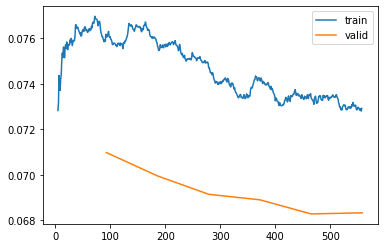

In [35]:
genre_classifier.recorder.plot_loss()

*Which instances had the highest loss?*

In [36]:
interp = ClassificationInterpretation.from_learner(genre_classifier)
interp.plot_top_losses(5)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,input,target,predicted,probability,loss
0,"xxbos xxmaj commander xxmaj alexandria xxmaj xxunk headed up nasa 's first deep - space mission to search for other habitable planets in distant galaxies . xxmaj where only two years have passed by for the crew of the xxmaj methuselah , fifteen hundred years have ticked by on xxmaj earth . xxmaj alex and her crew were prepared for that eventuality . xxmaj what they were n't prepared for was a nuclear war and the resulting catastrophic meteor shower that sent them hurling into xxmaj earth 's very distant , eerie future . xxmaj welcome to earth in the year 100 , xxrep 3 0 , 007 xxup a.d . xxmaj prepare to scream .",Adult Fiction (Erotica) ;Erotica (BDSM) ;Fantasy (Paranormal) ;Futuristic;Romance;Romance (Science Fiction Romance) ;Science Fiction (Aliens) ;Science Fiction (Time Travel),Science Fiction (Aliens) ;Science Fiction Fantasy;Space;Space (Space Opera),0.7123322486877441,0.3025014102458954
1,"xxbos xxmaj january 27 , 2027 - xxmaj one day around the xxunk after the last page of the xxmaj in the xxmaj company of xxmaj shadows series , seven stories show glimpses of the lives of fifteen characters , scattered across the globe . xxmaj in xxmaj ireland , an unexpected reunion takes a terrible turn . xxmaj in xxmaj australia , the tides are changing while those involved never stop watching . xxmaj in xxmaj mexico , fear brings uncertainty into a once strong relationship . xxmaj and in the xxmaj united xxmaj states , worlds are about to xxunk / 27 answers the important question : xxmaj what happens next ?",Dark;LGBT;Romance;Romance (M M Romance) ;Science Fiction (Dystopia) ;Short Stories;War (Military Fiction),Adventure (Survival) ;Apocalyptic (Post Apocalyptic) ;Horror;Horror (Zombies) ;Science Fiction (Apocalyptic) ;Science Fiction (Dystopia),0.9684410095214844,0.2673867642879486
2,"xxbos xxmaj in this relentlessly gripping psychological thriller , xxmaj johnny xxmaj xxunk plays xxmaj spencer xxmaj xxunk , an astronaut sent on a space shuttle mission with his partner , xxmaj captain xxmaj alex xxmaj xxunk . xxmaj while in space , an accident occurs that cuts all contact between the men and earth for two minutes . xxmaj both men return from the trip with no memory of those crucial minutes , and soon thereafter xxmaj xxunk mysteriously dies . xxmaj little by little , xxmaj spencer 's wife xxmaj jillian , pregnant with twins , begins to suspect that something happened on the mission during those two minutes … something that changed xxmaj spencer into something other than the man she loves … something that might mean the end of us all …",Adventure;Media Tie In;Mystery;Mystery (Crime) ;Spy Thriller (Espionage) ;Suspense;Thriller,Romance;Science Fiction (Time Travel),0.5831440091133118,0.2326933592557907
3,"xxbos xxmaj set in futuristic xxmaj metro xxmaj city , xxmaj astro xxmaj boy follows the story of a young robot who was created by a brilliant scientist in the image of the son he has lost . xxmaj this novel is based on the new animated film , includes 8 pages of full - color images from the movie , and is written by xxmaj new xxmaj york xxmaj times bestselling author xxmaj xxunk xxmaj west .",Action;Adventure;Childrens;Childrens (Juvenile) ;Comics (Superheroes) ;Science (Technology),Sequential Art (Comics) ;Sequential Art (Graphic Novels),0.6231475472450256,0.2186877280473709
4,"xxbos xxmaj dans une xxmaj france xxunk xxunk de la xxunk , un xxunk xxunk dans la xxunk xxunk . xxmaj xxunk xxunk par xxunk , il xxunk à une vie xxunk mais xxunk , xxunk des xxunk xxunk xxunk . xxmaj xxunk les forces en xxunk dans le pays ont xxunk le xxunk politique xxunk xxunk son xxunk . xxmaj cette implosion sans xxunk , sans xxunk xxunk , se xxunk comme un xxunk xxunk talent de xxunk , sa force xxunk nous xxunk sur un terrain xxunk et xxunk ; son regard sur notre civilisation xxunk fait xxunk dans ce roman les xxunk xxunk , les xxunk xxunk , une xxunk xxunk livre est une xxunk fable politique et morale ."

Let's save the model for later use 

In [37]:
genre_classifier.export('models/multi_genre_classifier.pkl') 

## Conclusion

In this notebook, we built a multi-label genre predictor. Now that we have created our model, it is super important to put it to the test and see how it works on unseen data. In the next notebook, we will use the model built here and create a genre predictor application.  

